# Modelado de Machine Learning para el cálculo de la antigüedad estimada para empleados dentro de Liverpool

In [17]:
# Librerías

In [18]:
''' 
    * Autor: Octavio Augusto Alemán Esparza
    * fecha: 12.11.2023
    * Titulo: model.ipynb
    * Descripción: Funciones para el modelado y estimación del servicio de un empleado dentro de Liverpool
'''

import pandas as pd #libreria standard para el manejo de datos
import numpy as np  #libreria standard para operaciones matemáticas
import matplotlib.pyplot as plt #libreria base para visualización de datos
import seaborn as sns #libreria avanzada para visualización de datos

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from collections import Counter

'''Plotly visualization .'''

import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

import warnings
warnings.filterwarnings('ignore')

# Carga de Datos

In [19]:
# Ruta de archivos
file_path = './data/time_series/'

# Nombre de archivo
file_name = 'data_for_model_with_risk.csv'

Visualización del archivo

In [20]:
# Carga de datos a un Dataframe
df = pd.read_csv(file_path + file_name)

# Definición de la primera columna como index
df.set_index(df.columns[0], inplace=True)
df.index.name = 'index'

# Visualización de las primeras 5 entradas
df.head(5)

,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,antiguedad,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo
index,,,,,,,,,,,,,,,,,
14742898,CeDis Regional Tacubaya,82,True,CeDis,1,29,False,2,False,0.227242,Hombre,-1,1,-1,29,Baja,Riesgo Alto
14691625,CeDis Regional Tacubaya,116,False,CeDis,0,25,False,2,False,0.320329,Hombre,-1,1,-1,25,Baja,Riesgo Alto
14714343,CeDis Regional Tacubaya,98,True,CeDis,3,39,False,2,False,0.271047,Mujer,-1,1,-1,40,Baja,Riesgo Alto
14790783,CeDis Regional Tacubaya,49,True,CeDis,0,22,False,2,False,0.136893,Hombre,-1,1,-1,22,Baja,Riesgo Alto
14701213,CeDis Regional Tacubaya,110,False,CeDis,0,18,False,2,False,0.303901,Hombre,-1,1,-1,18,Baja,Riesgo Alto


# Ajuste de datos

In [21]:
# Conversión de columnas categóricas a numericas
def dataToNumeric(df):

    df_categoric = df.select_dtypes(exclude= ['number'])

    label_encoder = LabelEncoder()
    for col in range (0, len(df_categoric.columns)):
        df[df_categoric.columns[col]] = label_encoder.fit_transform(df[df_categoric.columns[col]])

    return df

df = dataToNumeric(df)

# Visualización de resultados
df.head(5)

,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,antiguedad,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo
index,,,,,,,,,,,,,,,,,
14742898,103,82,1,0,1,29,0,2,0,0.227242,0,-1,1,-1,29,1,0
14691625,103,116,0,0,0,25,0,2,0,0.320329,0,-1,1,-1,25,1,0
14714343,103,98,1,0,3,39,0,2,0,0.271047,1,-1,1,-1,40,1,0
14790783,103,49,1,0,0,22,0,2,0,0.136893,0,-1,1,-1,22,1,0
14701213,103,110,0,0,0,18,0,2,0,0.303901,0,-1,1,-1,18,1,0


# Submuestreo aleatorio

In [22]:
def classProportion(df):
    # Calcula la diferencia en la columna 'Clase'
    difference = df['clase'].value_counts()

    colors = ['#CD137A', '#EEAABF']

    # Crea un gráfico de barras
    fig = go.Figure(data=[
        go.Bar(x=difference.index, 
               y=difference.values,
               marker_color=colors)
    ])

    # Configura el diseño del gráfico
    fig.update_layout(
        title='Distribución de Clases',
        title_x = 0.5,
        xaxis_title='Clase',
        yaxis_title='Total',
    )

    # Muestra el gráfico
    return fig.show()

classProportion(df)

Aleatorizar y particionar la muestra

In [23]:
df = df.sample(frac = 1, random_state=57)

def removeClass(df, class_to_drop, n):
    df_aux = df.copy()

    to_remove = df_aux[df_aux['clase'] == class_to_drop]
    to_remove = to_remove.sample(frac = 1, random_state = 23453)

    df_aux = df_aux.drop(to_remove.head(n).index)

    return df_aux

# Eliminar aleatoriamente N muestras
N = 60000

# Clase a eliminar (Renucnias)
drop_class = 1

# Remover filas
'''df = removeClass(df, 1, N)'''

# Visualización del Dataframe
df.sample(5)

,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,antiguedad,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo
index,,,,,,,,,,,,,,,,,
70370889,572,1,0,3,0,23,0,2,0,0.005476,1,-1,1,-1,23,1,2
12262297,372,369,0,1,0,18,0,8,0,7.101985,1,-1,2,-1,25,1,0
15018129,83,174,0,0,1,21,0,5,0,1.924709,1,-1,2,-1,23,1,0
70444342,562,63,0,3,0,32,0,3,0,0.353183,0,-1,1,-1,33,1,0
70522492,555,50,0,3,0,18,0,3,0,0.281999,1,-1,1,-1,18,1,0


Oversampling de la clase minoritaria

In [24]:
# Eliminar Ouytliers de Renuncias
aux = df[((df['clase'] == 1) & (df['antiguedad'] < 2)) ]
aux2 = df[df['clase'] == 0]
df = pd.concat([aux, aux2], axis = 0, ignore_index=True)
df.head(5)

,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,antiguedad,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo
0,428,287,0,3,0,35,0,3,1,1.577002,0,2,2,152,37,1,0
1,79,67,1,0,0,19,0,5,0,0.747433,0,-1,1,-1,20,1,0
2,83,3,1,0,0,23,0,2,0,0.010951,0,-1,1,-1,23,1,0
3,346,166,0,1,0,20,0,4,0,1.374401,1,-1,1,-1,22,1,0
4,344,8,1,1,0,18,0,2,0,0.024641,1,-1,1,-1,18,1,0


In [25]:

def smote(df):
    # La clase minoritaria es 0 en tu caso
    minority_class = 0

    # Número de instancias a agregar mediante oversampling
    oversample_count = N  

    # Identificar las muestras de la clase minoritaria
    minority_samples = df.copy() #[df['clase'] == minority_class]
    X = minority_samples.drop('clase', axis = 1)
    y = minority_samples['clase']

    # Realizar oversampling
    oversampled_minority = SMOTE(sampling_strategy=0.55, random_state=89)
    X, y = oversampled_minority.fit_resample(X, y)

    oversampled_minority = pd.concat([X, y], axis=1)
   
    print(Counter(y[y == 0]))

    return oversampled_minority


df = smote(df)
df.sample(5)

Counter({0: 47328})


,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,antiguedad,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,Nivel de Riesgo,clase
81771,66,118,0,0,1,27,0,7,0,1.960301,1,-1,2,-1,29,0,1
98150,528,122,0,3,0,37,0,13,0,4.489370,1,-1,5,-1,41,0,0
98397,307,278,0,1,0,19,0,12,0,6.671340,0,-1,6,-1,26,1,0
58162,68,42,0,0,0,23,0,2,0,0.117728,1,-1,1,-1,24,0,1
32113,68,48,1,0,1,28,0,4,0,0.402464,1,-1,3,-1,28,0,1


Nueva Distribución de Clases

In [26]:
classProportion(df)

# Filtrado de datos

In [27]:
df.drop(['clase', 'genero', 'eventual', 'sindicato'], axis = 1, inplace = True)

# Visualización del dataframe
df.head(5)

,ultima ubicacion,dias por posicion,area empresarial,hijos,edad ingreso,posiciones totales,liderazgo,antiguedad,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,Nivel de Riesgo
0,428,287,3,0,35,3,1,1.577002,2,2,152,37,0
1,79,67,0,0,19,5,0,0.747433,-1,1,-1,20,0
2,83,3,0,0,23,2,0,0.010951,-1,1,-1,23,0
3,346,166,1,0,20,4,0,1.374401,-1,1,-1,22,0
4,344,8,1,0,18,2,0,0.024641,-1,1,-1,18,0


# Transformación de los datos

Posicionar columna objetivo como la última columna

In [28]:
# Ubicar 'antiguedad' como la última columna
class_column = df['antiguedad']
df = df.drop('antiguedad', axis=1)
df['antiguedad'] = class_column

In [29]:
# Normalización
n_colsX = df.shape[1] - 1

X = df.iloc[:,0:n_colsX]
Y = df.iloc[:,n_colsX] 

rescaledX = StandardScaler().fit_transform(X)
newX    = pd.DataFrame(data=rescaledX,columns=X.columns)

# Nuevos datos escalados
newX.head(5)

,ultima ubicacion,dias por posicion,area empresarial,hijos,edad ingreso,posiciones totales,liderazgo,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,Nivel de Riesgo
0,0.553551,0.800697,1.615790,-0.534115,0.683178,-0.433286,4.782583,1.320049,-0.203750,0.186507,0.479914,-0.605046
1,-1.403043,-0.334995,-1.411411,-0.534115,-1.038877,-0.113810,-0.209092,-0.167345,-0.590514,-0.126829,-1.009110,-0.605046
2,-1.380617,-0.665379,-1.411411,-0.534115,-0.608364,-0.593024,-0.209092,-0.167345,-0.590514,-0.126829,-0.746341,-0.605046
3,0.093835,0.176066,-0.402344,-0.534115,-0.931249,-0.273548,-0.209092,-0.167345,-0.590514,-0.126829,-0.833931,-0.605046
4,0.082623,-0.639567,-0.402344,-0.534115,-1.146506,-0.593024,-0.209092,-0.167345,-0.590514,-0.126829,-1.184289,-0.605046


# Entrenamiento de los modelos

Conjuntos de entrenamiento y Prueba 

In [30]:
# Dividir datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(newX, Y, test_size=0.1, random_state=273)

Selección de modelos

In [31]:
models = []

models.append(('Linear Regression', LinearRegression()))
models.append(('Lasso', Lasso(random_state = 0)))
models.append(('Ridge', Ridge(alpha=0.001, random_state=0)))
models.append(('ElasticNet', ElasticNet(random_state=0)))
models.append(('Decission Tree Regressor', DecisionTreeRegressor(random_state=0)))
models.append(('RandomForestRegressor', RandomForestRegressor(n_estimators=200, random_state=0)))
models.append(('KNN', KNeighborsRegressor(n_jobs=-1)))
models.append(('Extra Trees', ExtraTreesRegressor(n_estimators=200, n_jobs=-1, random_state=0)))
#models.append(('Ada Boost', AdaBoostRegressor(random_state=0)))
#models.append(('GradientBoostingRegressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)))
#models.append(('SVM', SVR()))


Entrenamiento de los modelos

____________________________
Modelo: Linear Regression
Mean Squared Error: 0.17


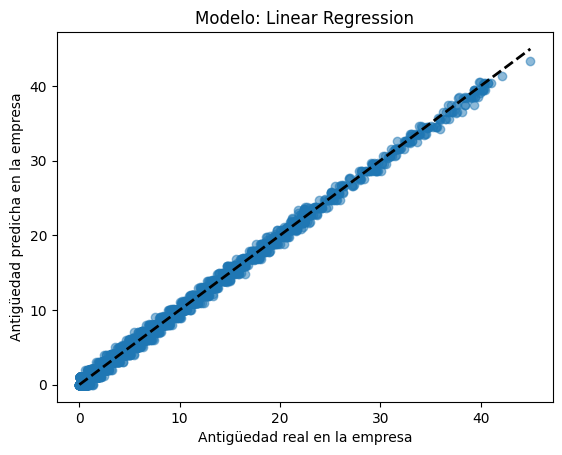

____________________________
Modelo: Lasso
Mean Squared Error: 9.7


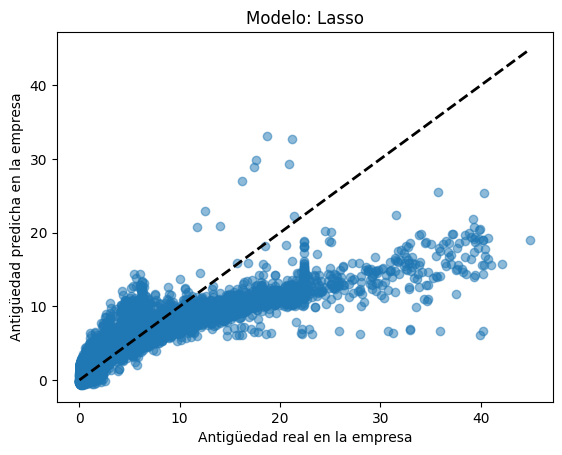

____________________________
Modelo: Ridge
Mean Squared Error: 0.17


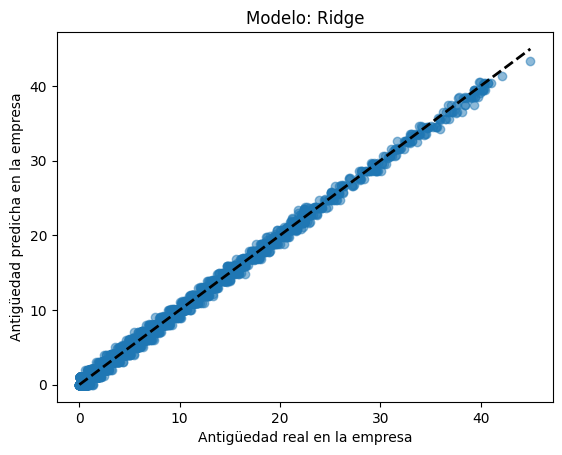

____________________________
Modelo: ElasticNet
Mean Squared Error: 10.58


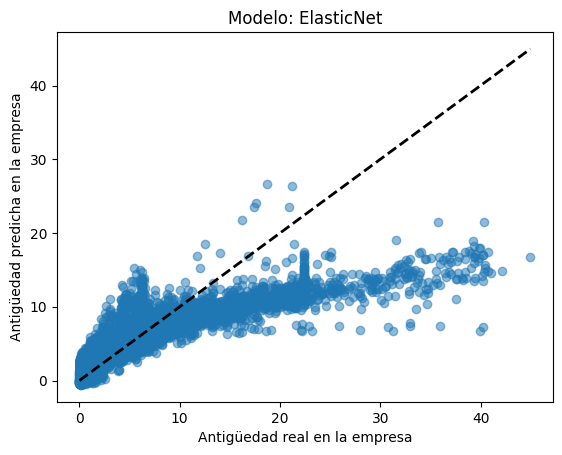

____________________________
Modelo: Decission Tree Regressor
Mean Squared Error: 0.36


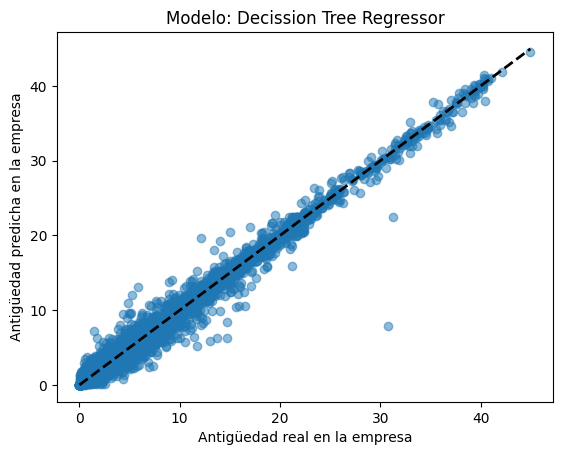

____________________________
Modelo: RandomForestRegressor
Mean Squared Error: 0.18


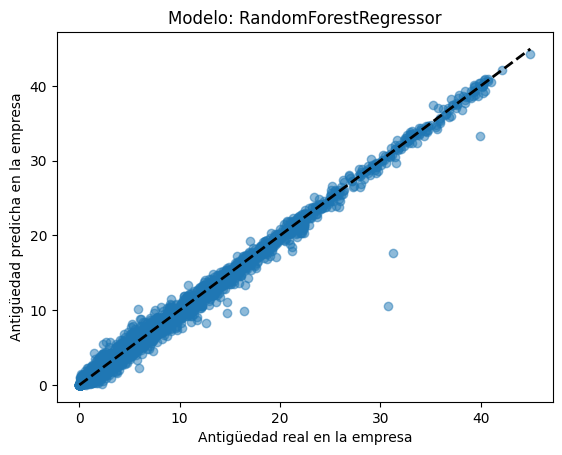

____________________________
Modelo: KNN
Mean Squared Error: 0.64


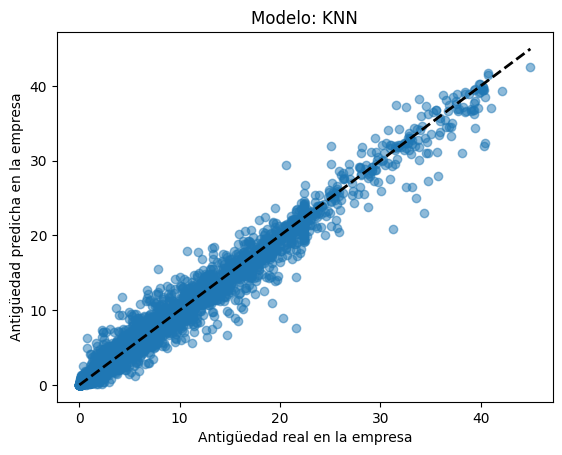

____________________________
Modelo: Extra Trees
Mean Squared Error: 0.09


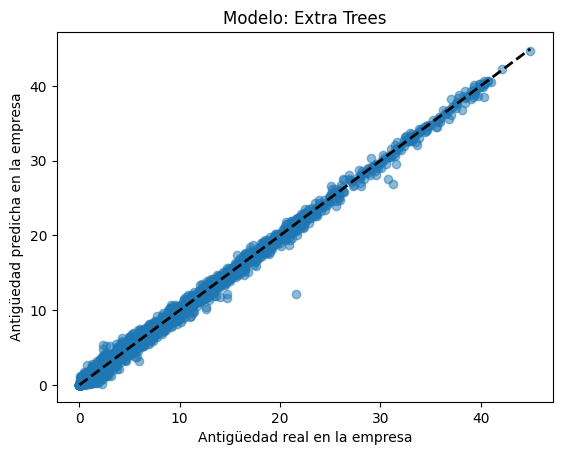

Proceso completado


In [32]:
for name, model in models:

    # Entrenar el modelo de Random Forest Regressor
    model = model
    model.fit(X_train, y_train)

    if 'Linear' in name:
        c= model.intercept_
        m=model.coef_

    # Evaluar el rendimiento del modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    print('____________________________')
    print(f'Modelo: {name}')
    print(f'Mean Squared Error: {round(mse, 2)}')

    # Visualizar las predicciones frente a los valores reales
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Antigüedad real en la empresa')
    plt.ylabel('Antigüedad predicha en la empresa')
    plt.title(f'Modelo: {name}')
    plt.show()

print("Proceso completado")

Función para gráficas de Evaluación

In [563]:
'''Function to plot scatter plot'''
def scatter_plot(x, y, title, xaxis, yaxis, size, c_scale):
    trace = go.Scatter(
    x = x,
    y = y,
    mode = 'markers',
    marker = dict(color = y, size = size, showscale = True, colorscale = c_scale))
    layout = go.Layout(hovermode= 'closest', title = title, xaxis = dict(title = xaxis), yaxis = dict(title = yaxis))
    fig = go.Figure(data = [trace], layout = layout)
    return iplot(fig)    

Puntaje d eentrenamiento

In [564]:
names = []
scores = []
for name, model in models:
    model.fit(X_train, y_train)
    scores.append(model.score(X_train, y_train))
    names.append(name)

#Plot dataframe of training accuracy.
train_score = pd.DataFrame(data = scores, columns = ['Training_R2'])
train_score.index = names
train_score = (train_score*100).round(4)
scatter_plot(train_score.index, train_score['Training_R2'], 'Training Score (R_Squared)', 'Models','% Training Score', 30, 'Rainbow')

RMSE

In [565]:
train_test_split_rmse = []

for name, model in models:
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mse = mean_squared_error(prediction, y_test)
    rmse = np.sqrt(mse)
    train_test_split_rmse.append(rmse)


train_test_score = pd.DataFrame(data = train_test_split_rmse, columns = ['Train_Test_RMSE'])
train_test_score.index = names
train_test_score = train_test_score.round(5)
x = train_test_score.index
y = train_test_score['Train_Test_RMSE']
title = "Models' Test Score (RMSE) on Holdout(30%) Set"
scatter_plot(x, y, title, 'Models','RMSE', 30, 'RdBu')

RMSE Validación Cruzada

In [566]:
cross_val_scores = []

for name, model in models:
    neg_x_val_score = cross_val_score(model, X_train, y_train, cv = 10, n_jobs = -1, scoring = 'neg_mean_squared_error')
    x_val_score = np.round(np.sqrt(-1*neg_x_val_score), 5)
    cross_val_scores.append(x_val_score.mean())

'''Plot data frame of cross validation scores.'''
x_val_score = pd.DataFrame(data = cross_val_scores, columns = ['Cross Validation Scores (RMSE)'])
x_val_score.index = names
x_val_score = x_val_score.round(5)
x = x_val_score.index
y = x_val_score['Cross Validation Scores (RMSE)']
title = "Models' 10-fold Cross Validation Scores (RMSE)"
scatter_plot(x, y, title, 'Models','RMSE', 30, 'Viridis')

Curvas de Aprendizaje

In [33]:
'''Create a function to plot learning curves.'''
def plot_learning_curve(model):
    from sklearn.model_selection import learning_curve
    
    # df_train_final is training matrix and y_train is target matrix.
    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, 
                                            train_sizes = np.linspace(0.01, 1.0, 20), cv = 10, scoring = 'neg_mean_squared_error', 
                                            n_jobs = -1, random_state = 42)
    
    
    # Create means and standard deviations of training set scores
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    # Create means and standard deviations of test set scores
    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  
    
    # Draw lines
    plt.plot(train_sizes, train_mean, 'o-', color = 'red',  label = 'Training score')
    plt.plot(train_sizes, test_mean, 'o-', color = 'green', label = 'Cross-validation score')
    
    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'r') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'g')
    
    
    # Create plot
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('Accuracy Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()

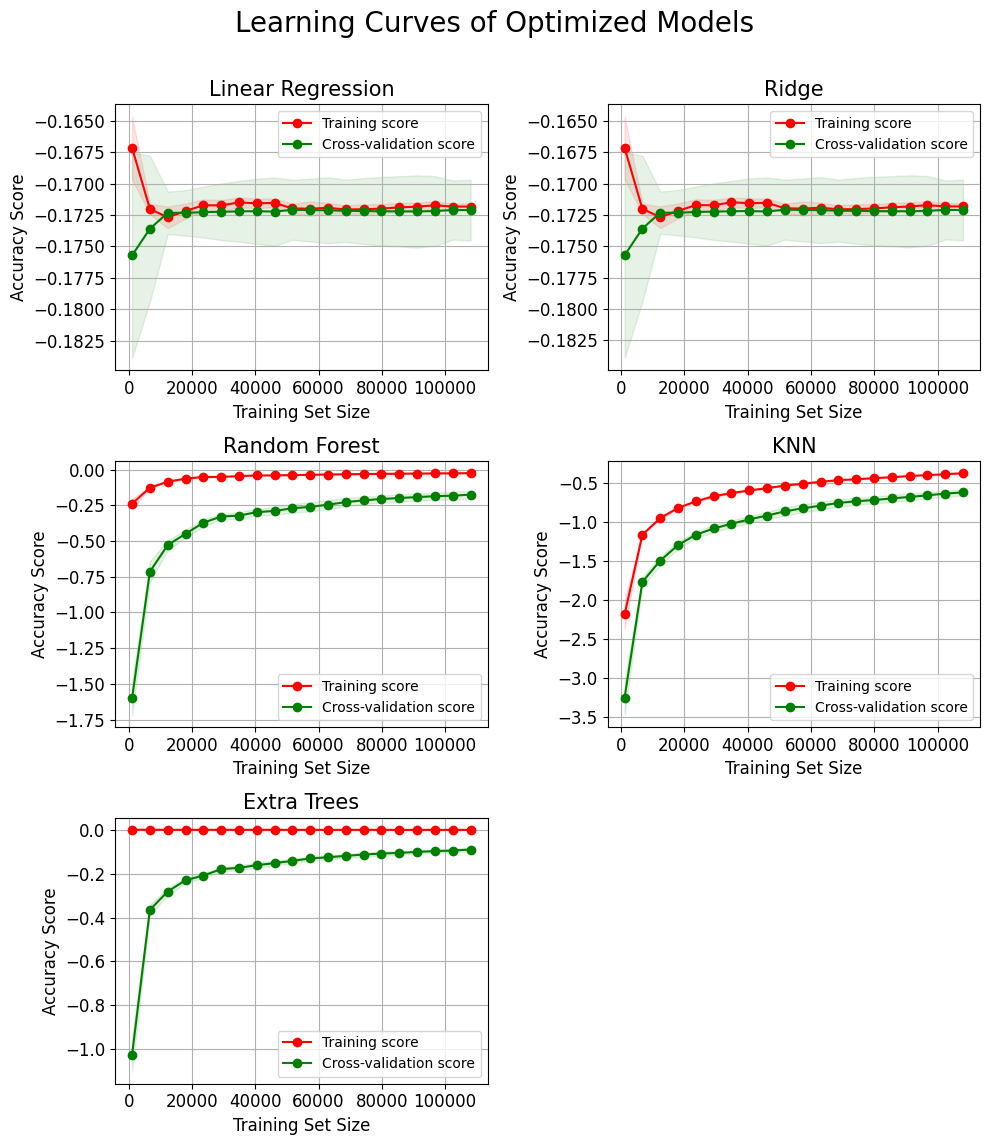

In [34]:
'''Now plot learning curves of the optimized models in subplots..'''
plt.figure(figsize = (10,12))
lc_models = [models[0][1], models[2][1], models[5][1], models[6][1], models[7][1]]
lc_labels = ['Linear Regression', 'Ridge', 'Random Forest', 'KNN', 'Extra Trees']

for ax, models, labels in zip (range(1,6), lc_models, lc_labels):
    plt.subplot(3,2,ax)
    plot_learning_curve(models)
    plt.title(labels, fontsize = 15)
plt.suptitle('Learning Curves of Optimized Models', fontsize = 20)
plt.tight_layout(rect = [0, 0.03, 1, 0.97])

# Funcionamiento del modelo
* Random Trees

In [35]:
# Carga de datos a un Dataframe
df = pd.read_csv(file_path + file_name)

# Definición de la primera columna como index
df.set_index(df.columns[0], inplace=True)
df.index.name = 'index'

# Visualización de las primeras 5 entradas
df.head(5)

# Conversión de columnas categóricas a numericas
def dataToNumeric(df):

    df_categoric = df.select_dtypes(exclude= ['number'])

    label_encoder = LabelEncoder()
    for col in range (0, len(df_categoric.columns)):
        df[df_categoric.columns[col]] = label_encoder.fit_transform(df[df_categoric.columns[col]])

    return df

df = dataToNumeric(df)

# Ubicar 'antiguedad' como la última columna
class_column = df['antiguedad']
df = df.drop('antiguedad', axis=1)
df['antiguedad'] = class_column

Datos de Prueba

In [36]:
test_data = df.copy()
test_data

,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo,antiguedad
index,,,,,,,,,,,,,,,,,
14742898,103,82,1,0,1,29,0,2,0,0,-1,1,-1,29,1,0,0.227242
14691625,103,116,0,0,0,25,0,2,0,0,-1,1,-1,25,1,0,0.320329
14714343,103,98,1,0,3,39,0,2,0,1,-1,1,-1,40,1,0,0.271047
14790783,103,49,1,0,0,22,0,2,0,0,-1,1,-1,22,1,0,0.136893
14701213,103,110,0,0,0,18,0,2,0,0,-1,1,-1,18,1,0,0.303901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270533,37,903,0,2,3,42,0,9,0,1,-1,3,-1,60,0,2,17.650924
105953,339,635,0,1,2,33,0,11,0,1,-1,5,-1,59,0,2,25.982204
61070,361,899,0,1,2,29,0,12,0,0,-1,7,-1,58,0,1,29.445585


In [37]:
def identify_service(df, model):
    aux = df.copy()

    # Eliminación de columnas no usadas
    aux.drop(['clase', 'genero', 'eventual', 'sindicato'], axis = 1, inplace = True)

    # Normalization
    n_colsX = aux.shape[1] - 1
    X = aux.iloc[:, 0:n_colsX]
    rescaledX = StandardScaler().fit_transform(X)
    newX = pd.DataFrame(data=rescaledX, columns=X.columns)

    # Use the model to predict
    y_pred = model.predict(newX)

    # Add the predicted values to the DataFrame
    df['Antigüedad Pronosticada'] = y_pred
    df['Antigüedad Pronosticada'] = df['Antigüedad Pronosticada'].astype(float)

    return df

prueba = identify_service(test_data, lc_models[3])

prueba


,ultima ubicacion,dias por posicion,eventual,area empresarial,hijos,edad ingreso,sindicato,posiciones totales,liderazgo,genero,posiciones hasta liderazgo,movimientos reales,dias hasta liderazgo,edad salida,clase,Nivel de Riesgo,antiguedad,Antigüedad Pronosticada
index,,,,,,,,,,,,,,,,,,
14742898,103,82,1,0,1,29,0,2,0,0,-1,1,-1,29,1,0,0.227242,0.194387
14691625,103,116,0,0,0,25,0,2,0,0,-1,1,-1,25,1,0,0.320329,0.292950
14714343,103,98,1,0,3,39,0,2,0,1,-1,1,-1,40,1,0,0.271047,0.269478
14790783,103,49,1,0,0,22,0,2,0,0,-1,1,-1,22,1,0,0.136893,0.114990
14701213,103,110,0,0,0,18,0,2,0,0,-1,1,-1,18,1,0,0.303901,0.302806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270533,37,903,0,2,3,42,0,9,0,1,-1,3,-1,60,0,2,17.650924,19.421881
105953,339,635,0,1,2,33,0,11,0,1,-1,5,-1,59,0,2,25.982204,24.203962
61070,361,899,0,1,2,29,0,12,0,0,-1,7,-1,58,0,1,29.445585,26.414039


# Guardado del modelo

In [38]:
from joblib import dump

def save_model(model):
    dump(model, './model_saves/regression_model_.joblib') 

save_model(lc_models[3])